# Load Packages

In [1]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
#import sklearn as sk
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
#from sklearn.preprocessing import Normalizer
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet50
import sys
!pip install rarfile
from rarfile import RarFile
!pip install segmentation-models
import segmentation_models as sm
!pip install git+https://github.com/davej23/image-segmentation-keras.git
from keras_segmentation.models import segnet
from keras.applications import vgg16
from sklearn.metrics import *
!pip install rioxarray
import rioxarray as rxr
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 50 kB 4.7 MB/s 
Segmentation Models: using `keras` framework.
  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-wlwbdcsm
  Running command git clone -q https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-wlwbdcsm
     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 25.9 MB/s 
     |████████████████████████████████| 948 kB 90.3 MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=34376 sha256=244fcef20dd0762f2098a2d7cc89ef1eebfd07821dc84835a972ee6e975dcf1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_rale68s/wheels/f4/fb/07/8f81ceb3d9fe936f5e4dcd1a64cbc489e42e6e7f9c2f166785
Successfully built keras-segmentation
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Su

     |████████████████████████████████| 45 kB 1.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 7.0 MB/s 
     |████████████████████████████████| 19.3 MB 126 kB/s 
  Created wheel for rioxarray: filename=rioxarray-0.6.1-py3-none-any.whl size=53246 sha256=9c641c59b6aab8a4ad033216719216674d133dfbce0603fb39f26cf33a2fcab9
  Stored in directory: /root/.cache/pip/wheels/a8/30/1c/78957e628ce5cc7f7109627c13624881a82efac11d28e96fef
Successfully built rioxarray


In [2]:
# Specify whether to download data or read in
download = True
base_dir = r"./Amazon Forest Dataset/"

In [3]:
# Download data

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

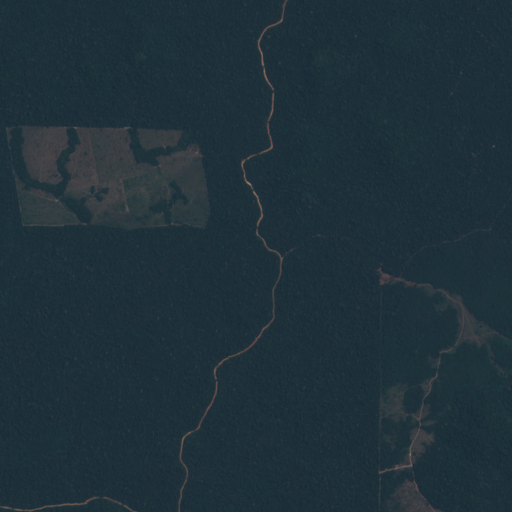

In [4]:
# Example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [6]:
def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [7]:
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [8]:
def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

In [9]:
#
# OLD FUNCTIONS
#
'''
def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    error = np.round(reconstruction).flatten() - (mask).flatten()
    return 1-(np.dot(error, error)/len(error))

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      prediction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
      err = np.round(prediction).flatten() - (mask[i]).flatten()
      scores.append(1-(np.dot(err, err)/len(err)))

    return scores



def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    r = np.round(reconstruction).flatten()
    m = mask.flatten()
    zero_correct = 0
    one_correct = 0
    zero_incorrect = 0
    one_incorrect = 0
    
    for i in range(len(r)):
        if r[i] == m[i]:
            if r[i] == 0:
                zero_correct += 1
            else:
                one_correct += 1
        else:
            if r[i] == 0:
                one_incorrect += 1
            else:
                zero_incorrect += 1

    recall_zero = zero_correct/(zero_correct + one_incorrect)
    recall_one = one_correct/(one_correct + zero_incorrect)
    recall = (recall_one + recall_zero) / 2

    return recall

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        r = np.round(reconstruction).flatten()
        m = mask[i].flatten()

        zero_correct = 0
        one_correct = 0
        zero_incorrect = 0
        one_incorrect = 0
        
        for i in range(len(r)):
            if r[i] == m[i]:
                if r[i] == 0:
                    zero_correct += 1
                else:
                    one_correct += 1
            else:
                if r[i] == 0:
                    one_incorrect += 1
                else:
                    zero_incorrect += 1

        recall_zero = zero_correct/(zero_correct + one_incorrect)
        recall_one = one_correct/(one_correct + zero_incorrect)
        recall.append((recall_one + recall_zero) / 2)

    return recall


def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    r = np.round(reconstruction).flatten()
    m = mask.flatten()
    zero_correct = 0
    one_correct = 0
    zero_incorrect = 0
    one_incorrect = 0
    
    for i in range(len(r)):
        if r[i] == m[i]:
            if r[i] == 0:
                zero_correct += 1
            else:
                one_correct += 1
        else:
            if r[i] == 0:
                one_incorrect += 1
            else:
                zero_incorrect += 1

    precision_zero = zero_correct/(zero_correct + zero_incorrect)
    precision_one = one_correct/(one_correct + one_incorrect)
    precision = (precision_one + precision_zero) / 2

    return precision

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        r = np.round(reconstruction).flatten()
        m = mask[i].flatten()

        zero_correct = 0
        one_correct = 0
        zero_incorrect = 0
        one_incorrect = 0
        
        for i in range(len(r)):
            if r[i] == m[i]:
                if r[i] == 0:
                    zero_correct += 1
                else:
                    one_correct += 1
            else:
                if r[i] == 0:
                    one_incorrect += 1
                else:
                    zero_incorrect += 1

        precision_zero = zero_correct/(zero_correct + zero_incorrect)
        precision_one = one_correct/(one_correct + one_incorrect)
        precision.append((precision_one + precision_zero) / 2)

    return precision


def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))
    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)
    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

'''

'\ndef score_eval(model, image, mask): # Gives score of mask vs prediction\n  if type(image) != list:   \n    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])\n    error = np.round(reconstruction).flatten() - (mask).flatten()\n    return 1-(np.dot(error, error)/len(error))\n\n  else: # If a list of images input, find accuracy for each\n    scores = []\n    for i in range(len(image)):\n      prediction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])\n      err = np.round(prediction).flatten() - (mask[i]).flatten()\n      scores.append(1-(np.dot(err, err)/len(err)))\n\n    return scores\n\n\n\ndef recall_eval(model, image, mask): # Find recall score\n  if type(image) != list:   \n    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])\n    r = np.round(reconstruction).flatten()\n    m = mask.flatten()\n    zero_correct = 0\n    one_correct = 0\n    zero_incorrect = 0\n    one_incorrect = 0\n    \n    for i in range(

# Ingest and Process Amazon RGB Dataset

In [10]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [11]:
# Pre-process data
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

training_images = training_images[0:25]
training_masks = training_masks[0:25]

In [12]:
# Create TensorFlow datasets for training and validation sets
#train_df = tf.data.Dataset.from_tensor_slices((training_images, training_masks))
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [13]:
# Load in augmented images (capped at 500 for sake of RAM limits in Colab)
# Ingest images
'''
## Training images
training_images_augmented = []
training_masks_augmented = []
for n in os.listdir(r"augmented/images/")[0:500]:
  im = PIL.Image.open(r"augmented/images/{}".format(n))
  im = np.array(im)/255
  im = im.reshape(1,512,512,3)
  im = im.astype('float32')
  training_images_augmented.append(im)

  im2 = PIL.Image.open(r"augmented/masks/{}".format(n))
  im2 = np.round(np.array(im2)/255)
  im2 = im2[:512,:512]
  im2 = im2.reshape(1,512,512,1)
  im2 = im2.astype('float32')
  training_masks_augmented.append(im2)

# Create TensorFlow datasets for training and validation sets
train_df = tf.data.Dataset.from_tensor_slices((training_images_augmented, training_masks_augmented))
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))
'''

'\n## Training images\ntraining_images_augmented = []\ntraining_masks_augmented = []\nfor n in os.listdir(r"augmented/images/")[0:500]:\n  im = PIL.Image.open(r"augmented/images/{}".format(n))\n  im = np.array(im)/255\n  im = im.reshape(1,512,512,3)\n  im = im.astype(\'float32\')\n  training_images_augmented.append(im)\n\n  im2 = PIL.Image.open(r"augmented/masks/{}".format(n))\n  im2 = np.round(np.array(im2)/255)\n  im2 = im2[:512,:512]\n  im2 = im2.reshape(1,512,512,1)\n  im2 = im2.astype(\'float32\')\n  training_masks_augmented.append(im2)\n\n# Create TensorFlow datasets for training and validation sets\ntrain_df = tf.data.Dataset.from_tensor_slices((training_images_augmented, training_masks_augmented))\nvalidation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))\n'

In [14]:
#
# Data loader from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [15]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
validation = trainGenerator(1, v_images, v_masks, data_gen_args, save_to_dir=None)

In [16]:
# Show example of augmented image

#x_batch, y_batch = next(train)
#plt.imshow(x_batch.reshape(512,512,3))

In [17]:
#np.mean(score_eval(model1, validation_images, validation_masks))

In [18]:
#np.mean(score_eval(model2, validation_images, validation_masks))

# Ingest and Process 4-band Datasets

## 4-band Amazon dataset

https://zenodo.org/record/4498086#.YMh3GfKSmCU

In [ ]:
download = True # True if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [ ]:
# Download data (Amazon)

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()


In [ ]:
# Ingest images

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

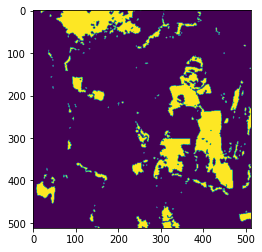

In [ ]:
a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,training_masks_list2[20])))[0,:,:])
plt.imshow(a)

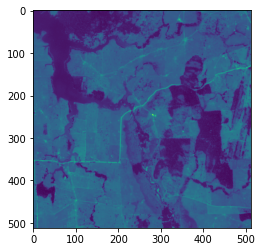

In [ ]:
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

(512, 512, 4)


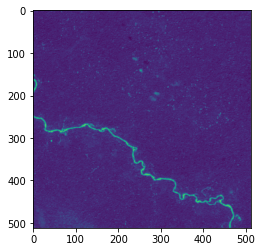

In [ ]:
b = training_images2[0].T
print(b.shape)
plt.imshow(b[:,:,0])

(512, 512, 4)


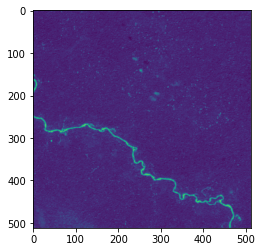

In [ ]:
c = b.reshape(1,512,512,4)
d = c.reshape(512,512,4)
print(d.shape)
plt.imshow(d[:,:,0])

(512, 512, 1)


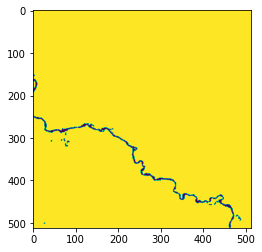

In [ ]:
a = training_masks2[0].T
print(a.shape)
plt.imshow(a.reshape(512,512))

In [ ]:
# Pre-process data
for i in range(len(training_images2)):
  #training_images2[i] = training_images2[i].reshape(1,512,512,4)
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  #training_masks[i] = training_masks[i][:512,:512]
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  #validation_images2[i] = validation_images2[i].reshape(1,512,512,4)
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  #validation_masks2[i] = validation_masks2[i][:512,:512]
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  #test_images2[i] = test_images2[i].reshape(1,512,512,4)
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  #test_masks2[i] = test_masks2[i][:512,:512]
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [ ]:
# Reshape for data generator
'''
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i][0]
'''

'\nfor i in range(len(training_images2)):\n  training_images2[i] = training_images2[i][0]\n'

In [ ]:
#
# Produce generators for training images
#
'''
t_images2 = np.stack(training_images2[0:250])
t_masks2 = np.stack(training_masks2[0:250])

train2 = trainGenerator(1, t_images2, t_masks2, data_gen_args, save_to_dir=None)
'''

'\nt_images2 = np.stack(training_images2[0:250])\nt_masks2 = np.stack(training_masks2[0:250])\n\ntrain2 = trainGenerator(1, t_images2, t_masks2, data_gen_args, save_to_dir=None)\n'

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

## 4-band Atlantic Forest dataset

https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1

In [ ]:
download = True # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [ ]:
# Download data (Atlantic Forest)
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()


In [ ]:
# Ingest images

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [ ]:
# Pre-process data
for i in range(len(training_images3)):
  #training_images3[i] = training_images3[i].reshape(1,512,512,4)
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  #training_masks3[i] = training_masks3[i][:512,:512]
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  #validation_images3[i] = validation_images3[i].reshape(1,512,512,4)
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  #validation_masks3[i] = validation_masks3[i][:512,:512]
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  #test_images3[i] = test_images3[i].reshape(1,512,512,4)
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  #test_masks3[i] = test_masks3[i][:512,:512]
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

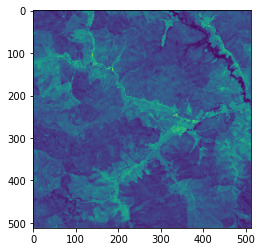

In [ ]:
plt.imshow(training_images3[0].reshape(512,512,4)[:,:,0])

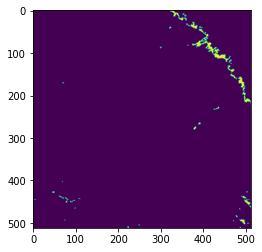

In [ ]:
plt.imshow(training_masks3[0].reshape(512,512,1)[:,:,0])

In [ ]:
# Reshape for data generator
'''
for i in range(len(training_images3)):
  training_images3[i] = training_images3[i][0]
  training_masks3[i] = training_masks3[i][0]
'''

'\nfor i in range(len(training_images3)):\n  training_images3[i] = training_images3[i][0]\n  training_masks3[i] = training_masks3[i][0]\n'

In [ ]:
#
# Produce generators for training images
#
'''
t_images3 = np.stack(training_images3[0:250])
t_masks3 = np.stack(training_masks3[0:250])

train3 = trainGenerator(1, t_images3, t_masks3, data_gen_args, save_to_dir=None)
'''

'\nt_images3 = np.stack(training_images3[0:250])\nt_masks3 = np.stack(training_masks3[0:250])\n\ntrain3 = trainGenerator(1, t_images3, t_masks3, data_gen_args, save_to_dir=None)\n'

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## U-Net

In [ ]:
def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
def UNet(trained_weights = None, input_size = (512,512,4), drop_rate = 0.25, lr=0.0001):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    #up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    #up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    #up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    #up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')


    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
UNet().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 512, 512, 4)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 512, 512, 64)    2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (1, 512, 512, 64)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (1, 512, 512, 64)    36928       activation[0][0]                 
______________________________________________________________________________________________

## Attention U-Net

https://arxiv.org/pdf/1804.03999.pdf - Attention Mechanism Paper

In [ ]:
def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.sum(targets * inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def DiceLoss(targets, inputs, smooth=1e-6):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
def spatial_attention(x):

  avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
  max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)

  concat = concatenate([avg_pool, max_pool], axis=3)

  #out = convBlock(concat, 2, 2, act='sigmoid')
  out = Conv2D(1, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = 'he_normal')(concat)
  out = Activation('sigmoid')(out)

  out = multiply([x, out])

  return out


def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Initial gate
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    ##phi_g = Conv2DTranspose(inter_shape, kernel_size = 2, strides = 2, padding = 'same', kernel_initializer='he_normal')(phi_g)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    #upsample_psi = Conv2DTranspose(K.int_shape(sigmoid_xg)[3], 2, 2, kernel_initializer='he_normal')(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])
    ##y = Conv2D(K.int_shape(y)[3], 1, 1, kernel_initializer='he_normal')(y)

    return y


def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=32):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    ##up4 = (UpSampling2D(size = (2,2))(conv3))
    #up4 = convBlock(up4, 8 * filter_base, kernel=3)
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    ##up5 = (UpSampling2D(size = (2,2))(conv4))
    #up5 = convBlock(up5, 4 * filter_base, kernel=3)
    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    ##up6 = (UpSampling2D(size = (2,2))(conv5))
    #up6 = convBlock(up6, 2 * filter_base, kernel=3)
    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    ##up7 = (UpSampling2D(size = (2,2))(conv6))
    #up7 = convBlock(up7, 1 * filter_base, kernel=3)
    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
UNetAM(filter_base=16).summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
conv2d_1192 (Conv2D)            (1, 512, 512, 16)    448         input_42[0][0]                   
__________________________________________________________________________________________________
activation_1080 (Activation)    (1, 512, 512, 16)    0           conv2d_1192[0][0]                
__________________________________________________________________________________________________
conv2d_1193 (Conv2D)            (1, 512, 512, 16)    2320        activation_1080[0][0]            
___________________________________________________________________________________________

# Train on RGB feature data

## U-Net

In [ ]:
# Train U-Net with generator
model_unet = UNet(input_size=(512,512,3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet.fit(train, steps_per_epoch=100, epochs=30, validation_data = validation_df, callbacks=[save_model])

Epoch 1/30
100/100 [==============================] - 16s 133ms/step - loss: 0.5338 - accuracy: 0.7233 - mse: 0.1823 - val_loss: 0.3456 - val_accuracy: 0.8332 - val_mse: 0.1102

Epoch 00001: val_accuracy improved from -inf to 0.83318, saving model to unet-3d.hdf5
Epoch 2/30
100/100 [==============================] - 12s 122ms/step - loss: 0.2398 - accuracy: 0.9133 - mse: 0.0677 - val_loss: 0.2095 - val_accuracy: 0.9185 - val_mse: 0.0616

Epoch 00002: val_accuracy improved from 0.83318 to 0.91851, saving model to unet-3d.hdf5
Epoch 3/30
100/100 [==============================] - 12s 122ms/step - loss: 0.2016 - accuracy: 0.9230 - mse: 0.0577 - val_loss: 0.2192 - val_accuracy: 0.9184 - val_mse: 0.0629

Epoch 00003: val_accuracy did not improve from 0.91851
Epoch 4/30
100/100 [==============================] - 12s 122ms/step - loss: 0.2037 - accuracy: 0.9270 - mse: 0.0562 - val_loss: 0.2040 - val_accuracy: 0.9219 - val_mse: 0.0592

Epoch 00004: val_accuracy improved from 0.91851 to 0.92190

In [ ]:
# Save model
#model_unet.save('unet.h5')

# Save weights
#model_unet.save_weights('weights.h5')

# Save model history
np.save('unet-3d-history.npy',model_unet.history.history)

In [ ]:
!cp unet-3d.hdf5 drive/MyDrive/Diss/
!cp unet-3d-history.npy drive/MyDrive/Diss/

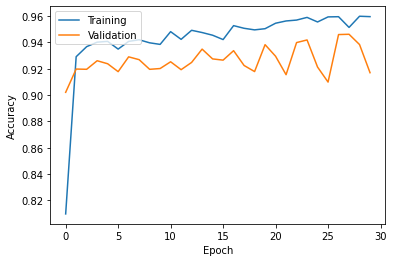

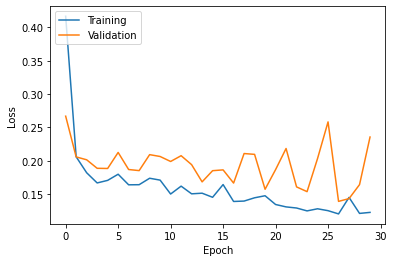

In [ ]:
# Plot accuracy and loss 

## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Show model structure
##model_unet.summary()

In [ ]:
# Show picture of model structure
##keras.utils.plot_model(model_unet, show_shapes=True, show_layer_names=True)

## Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_model_am = ModelCheckpoint('unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/50
100/100 [==============================] - 13s 86ms/step - loss: 0.5839 - accuracy: 0.6929 - mse: 0.2037 - val_loss: 0.6179 - val_accuracy: 0.5509 - val_mse: 0.2319

Epoch 00001: val_accuracy improved from -inf to 0.55089, saving model to unet-attention-3d.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
100/100 [==============================] - 7s 71ms/step - loss: 0.3924 - accuracy: 0.8384 - mse: 0.1210 - val_loss: 0.1948 - val_accuracy: 0.9292 - val_mse: 0.0543

Epoch 00002: val_accuracy improved from 0.55089 to 0.92922, saving model to unet-attention-3d.hdf5
Epoch 3/50
100/100 [==============================] - 7s 72ms/step - loss: 0.2470 - accuracy: 0.9016 - mse: 0.0726 - val_loss: 0.1720 - val_accuracy: 0.9372 - val_mse: 0.0480

Epoch 00003: val_accuracy improved from 0.92922 to 0.93718, saving model to unet-attention-3d.hdf5
Epoch 4/50
100/100 [==============================] - 7s 73ms/step - loss: 0.2254 - accuracy: 0.9151 - mse: 0.0637 - val_loss: 0.2282 - val_accuracy: 0.9217 - val_mse: 0.0629

Epoch 00004: val_accuracy did not improve from 0.93718
Epoch 5/50
100/100 [==============================] - 7s 72ms/step - loss: 0.1945 - accuracy: 0.9258 - mse: 0.0548 - val_loss: 0.1725 - val_accuracy: 0.9359 - val_mse: 0.0486

Epoch 00005: val_accuracy did not improve f

In [ ]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)

In [ ]:
!cp unet-attention-3d.hdf5 drive/MyDrive/Diss/
!cp unet-attention-3d-history.npy drive/MyDrive/Diss/

# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band = UNet()
save_model_4band = ModelCheckpoint('unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
#train2 = trainGenerator(1, t_images2, t_masks2, data_gen_args, save_to_dir=None)

model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
250/250 [==============================] - 37s 136ms/step - loss: 0.4937 - accuracy: 0.7531 - mse: 0.1643 - val_loss: 0.2363 - val_accuracy: 0.9101 - val_mse: 0.0693

Epoch 00001: val_accuracy improved from -inf to 0.91010, saving model to unet-4d.hdf5
Epoch 2/20
250/250 [==============================] - 32s 130ms/step - loss: 0.2102 - accuracy: 0.9195 - mse: 0.0606 - val_loss: 0.1731 - val_accuracy: 0.9354 - val_mse: 0.0495

Epoch 00002: val_accuracy improved from 0.91010 to 0.93535, saving model to unet-4d.hdf5
Epoch 3/20
250/250 [==============================] - 32s 130ms/step - loss: 0.1661 - accuracy: 0.9366 - mse: 0.0475 - val_loss: 0.1539 - val_accuracy: 0.9430 - val_mse: 0.0437

Epoch 00003: val_accuracy improved from 0.93535 to 0.94297, saving model to unet-4d.hdf5
Epoch 4/20
250/250 [==============================] - 32s 130ms/step - loss: 0.1413 - accuracy: 0.9462 - mse: 0.0403 - val_loss: 0.1378 - val_accuracy: 0.9478 - val_mse: 0.0395

Epoch 00004: val_accurac

In [ ]:
# Save model history
np.save('unet-4d-history.npy',model_unet_4band.history.history)

In [ ]:
!cp unet-4d.hdf5 drive/MyDrive/Diss/
!cp unet-4d-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
#train2 = trainGenerator(1, t_images2, t_masks2, data_gen_args, save_to_dir=None)

model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
250/250 [==============================] - 13s 37ms/step - loss: 0.7066 - accuracy: 0.7199 - mse: 0.1933 - val_loss: 0.2289 - val_accuracy: 0.9138 - val_mse: 0.0667

Epoch 00001: val_accuracy improved from -inf to 0.91378, saving model to unet-attention-4d.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
250/250 [==============================] - 8s 31ms/step - loss: 0.2318 - accuracy: 0.9092 - mse: 0.0676 - val_loss: 0.1856 - val_accuracy: 0.9311 - val_mse: 0.0537

Epoch 00002: val_accuracy improved from 0.91378 to 0.93110, saving model to unet-attention-4d.hdf5
Epoch 3/60
250/250 [==============================] - 8s 31ms/step - loss: 0.1709 - accuracy: 0.9319 - mse: 0.0500 - val_loss: 0.1578 - val_accuracy: 0.9403 - val_mse: 0.0458

Epoch 00003: val_accuracy improved from 0.93110 to 0.94030, saving model to unet-attention-4d.hdf5
Epoch 4/60
250/250 [==============================] - 8s 31ms/step - loss: 0.1479 - accuracy: 0.9429 - mse: 0.0427 - val_loss: 0.1421 - val_accuracy: 0.9449 - val_mse: 0.0417

Epoch 00004: val_accuracy improved from 0.94030 to 0.94492, saving model to unet-attention-4d.hdf5
Epoch 5/60
250/250 [==============================] - 8s 31ms/step - loss: 0.1331 - accuracy: 0.9498 - mse: 0.0381 - val_loss: 0.1268 - val_accuracy: 0.9510 - val_mse: 0.0371


In [ ]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

In [ ]:
!cp unet-attention-4d.hdf5 drive/MyDrive/Diss/
!cp unet-attention-4d-history.npy drive/MyDrive/Diss/

## Train on 4-band Atlantic data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band_atlantic = UNet()
save_model_4band_atlantic = ModelCheckpoint('unet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
#train3 = trainGenerator(1, t_images3, t_masks3, data_gen_args, save_to_dir=None)

model_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 20, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_atlantic])

Epoch 1/20
250/250 [==============================] - 37s 135ms/step - loss: 0.5139 - accuracy: 0.7163 - mse: 0.1757 - val_loss: 0.3600 - val_accuracy: 0.8477 - val_mse: 0.1199

Epoch 00001: val_accuracy improved from -inf to 0.84766, saving model to unet-4d-atlantic.hdf5
Epoch 2/20
250/250 [==============================] - 33s 130ms/step - loss: 0.3526 - accuracy: 0.8406 - mse: 0.1183 - val_loss: 0.3359 - val_accuracy: 0.8777 - val_mse: 0.1098

Epoch 00002: val_accuracy improved from 0.84766 to 0.87767, saving model to unet-4d-atlantic.hdf5
Epoch 3/20
250/250 [==============================] - 33s 130ms/step - loss: 0.3285 - accuracy: 0.8550 - mse: 0.1085 - val_loss: 0.3215 - val_accuracy: 0.8720 - val_mse: 0.1039

Epoch 00003: val_accuracy did not improve from 0.87767
Epoch 4/20
250/250 [==============================] - 33s 130ms/step - loss: 0.2992 - accuracy: 0.8679 - mse: 0.0959 - val_loss: 0.2911 - val_accuracy: 0.8768 - val_mse: 0.0918

Epoch 00004: val_accuracy did not improv

In [ ]:
# Save model history
np.save('unet-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

In [ ]:
!cp unet-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp unet-4d-atlantic-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('unet-attention-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
#train3 = trainGenerator(1, t_images3, t_masks3, data_gen_args, save_to_dir=None)

model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

Epoch 1/60
250/250 [==============================] - 13s 37ms/step - loss: 0.4958 - accuracy: 0.7373 - mse: 0.1693 - val_loss: 0.3287 - val_accuracy: 0.8650 - val_mse: 0.1054

Epoch 00001: val_accuracy improved from -inf to 0.86501, saving model to unet-attention-4d-atlantic.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
250/250 [==============================] - 8s 31ms/step - loss: 0.3095 - accuracy: 0.8724 - mse: 0.0990 - val_loss: 0.3058 - val_accuracy: 0.8690 - val_mse: 0.0971

Epoch 00002: val_accuracy improved from 0.86501 to 0.86896, saving model to unet-attention-4d-atlantic.hdf5
Epoch 3/60
250/250 [==============================] - 8s 31ms/step - loss: 0.2906 - accuracy: 0.8778 - mse: 0.0921 - val_loss: 0.3000 - val_accuracy: 0.8672 - val_mse: 0.0957

Epoch 00003: val_accuracy did not improve from 0.86896
Epoch 4/60
250/250 [==============================] - 8s 31ms/step - loss: 0.2776 - accuracy: 0.8798 - mse: 0.0879 - val_loss: 0.2767 - val_accuracy: 0.8733 - val_mse: 0.0879

Epoch 00004: val_accuracy improved from 0.86896 to 0.87328, saving model to unet-attention-4d-atlantic.hdf5
Epoch 5/60
250/250 [==============================] - 8s 31ms/step - loss: 0.2641 - accuracy: 0.8847 - mse: 0.0830 - val_loss: 0.2624 - val_accuracy: 0.8842 - val_mse: 0.0823

Epoch 00005: val_accuracy

In [ ]:
# Save model history
np.save('unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

In [ ]:
!cp unet-attention-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp unet-attention-4d-atlantic-history.npy drive/MyDrive/Diss/

# Plot validation image, with mask, and reconstructions

<Figure size 432x288 with 0 Axes>

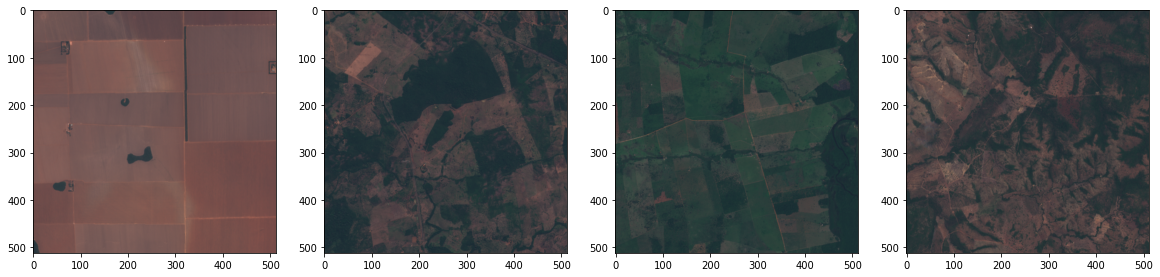

In [ ]:
# Plot a selection of validation set images
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(validation_images[1].reshape(512,512,3))
ax[1].imshow(validation_images[2].reshape(512,512,3))
ax[2].imshow(validation_images[3].reshape(512,512,3))
ax[3].imshow(validation_images[4].reshape(512,512,3))

<Figure size 432x288 with 0 Axes>

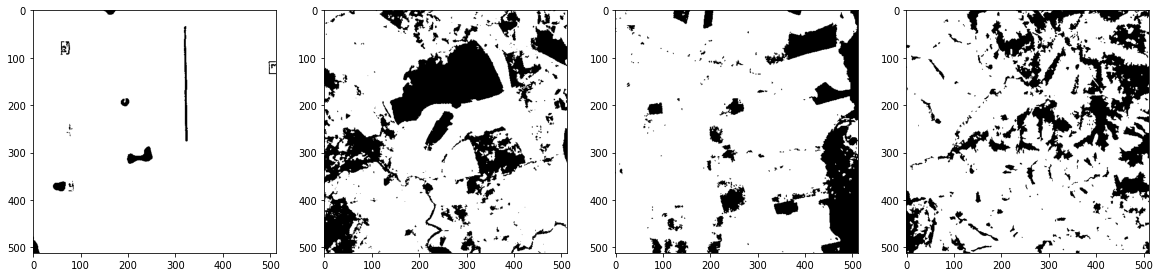

In [ ]:
# Plot corresponding validation set masks
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(validation_masks[1].reshape(512,512), cmap='gray')
ax[1].imshow(validation_masks[2].reshape(512,512), cmap='gray')
ax[2].imshow(validation_masks[3].reshape(512,512), cmap='gray')
ax[3].imshow(validation_masks[4].reshape(512,512), cmap='gray')

<Figure size 432x288 with 0 Axes>

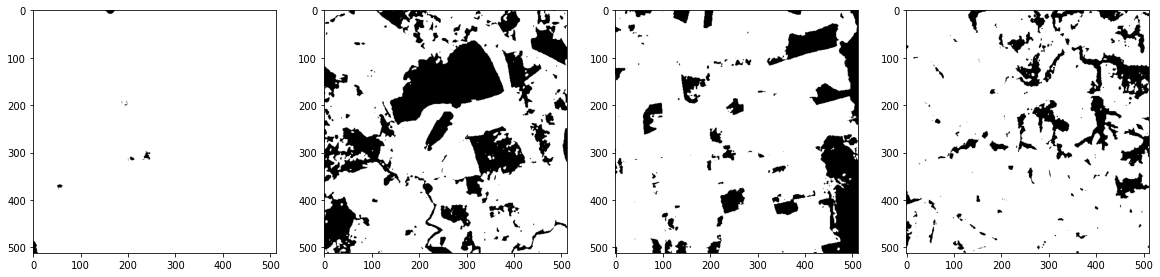

In [ ]:
# Plot reconstructions/predictions of masks for corresponding validation set images (rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model_unet, validation_images[1], rounded=True), cmap='gray')
ax[1].imshow(reconstruct_array(model_unet, validation_images[2], rounded=True), cmap='gray')
ax[2].imshow(reconstruct_array(model_unet, validation_images[3], rounded=True), cmap='gray')
ax[3].imshow(reconstruct_array(model_unet, validation_images[4], rounded=True), cmap='gray')

<Figure size 432x288 with 0 Axes>

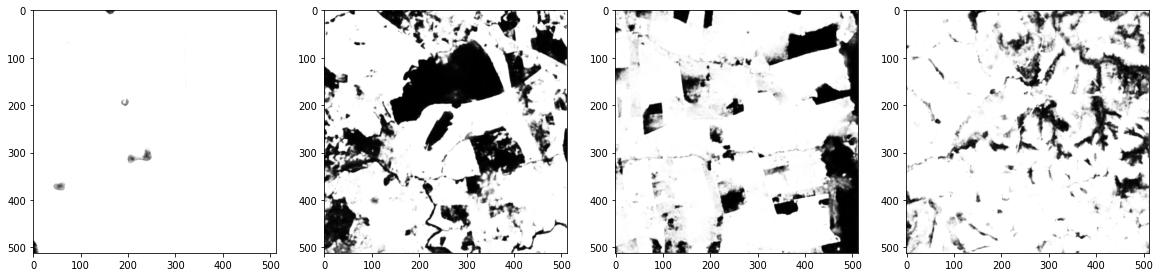

In [ ]:
# Plot reconstructions/predictions of masks for corresponding validation set images (not rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model_unet, validation_images[1], rounded=False), cmap='gray')
ax[1].imshow(reconstruct_array(model_unet, validation_images[2], rounded=False), cmap='gray')
ax[2].imshow(reconstruct_array(model_unet, validation_images[3], rounded=False), cmap='gray')
ax[3].imshow(reconstruct_array(model_unet, validation_images[4], rounded=False), cmap='gray')

# Plot test images and reconstructions

<Figure size 432x288 with 0 Axes>

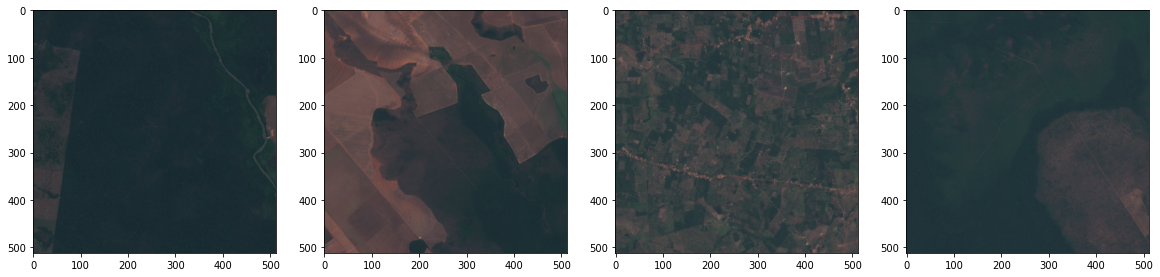

In [ ]:
# Plot a selection of test set images
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(test_images[1].reshape(512,512,3))
ax[1].imshow(test_images[2].reshape(512,512,3))
ax[2].imshow(test_images[3].reshape(512,512,3))
ax[3].imshow(test_images[4].reshape(512,512,3))

<Figure size 432x288 with 0 Axes>

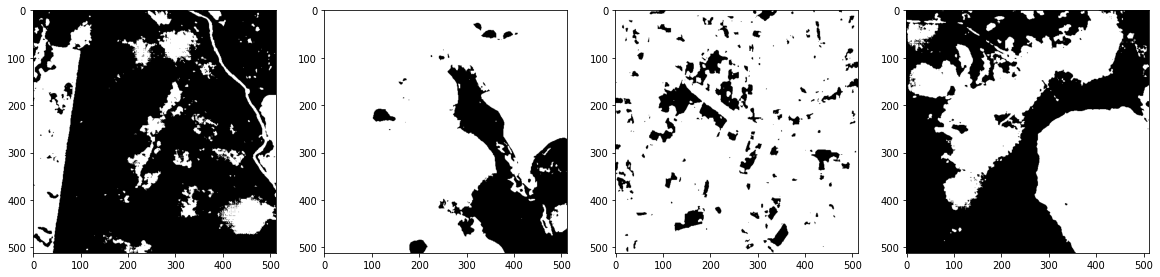

In [ ]:
# Plot corresponding reconstructions/predictions (rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model_unet, test_images[1].reshape(1,512,512,3), rounded=True), cmap='gray')
ax[1].imshow(reconstruct_array(model_unet, test_images[2].reshape(1,512,512,3), rounded=True), cmap='gray')
ax[2].imshow(reconstruct_array(model_unet, test_images[3].reshape(1,512,512,3), rounded=True), cmap='gray')
ax[3].imshow(reconstruct_array(model_unet, test_images[4].reshape(1,512,512,3), rounded=True), cmap='gray')

<Figure size 432x288 with 0 Axes>

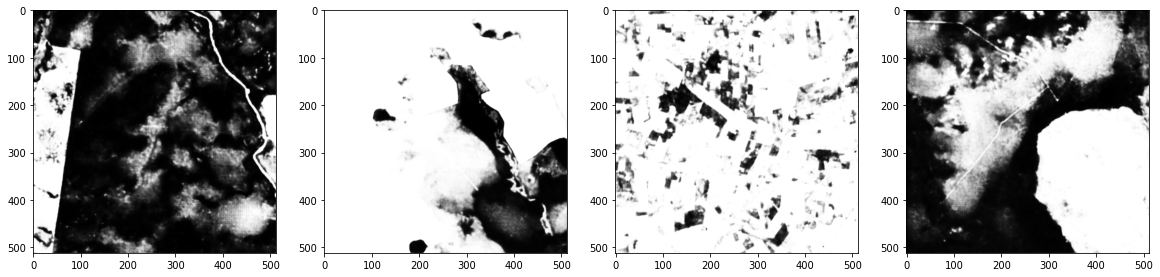

In [ ]:
# Plot corresponding reconstructions/predictions (not rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model_unet, test_images[1].reshape(1,512,512,3)), cmap='gray')
ax[1].imshow(reconstruct_array(model_unet, test_images[2].reshape(1,512,512,3)), cmap='gray')
ax[2].imshow(reconstruct_array(model_unet, test_images[3].reshape(1,512,512,3)), cmap='gray')
ax[3].imshow(reconstruct_array(model_unet, test_images[4].reshape(1,512,512,3)), cmap='gray')

# ResNet50-SegNet

**Links to review**

https://arxiv.org/abs/1512.03385 -- ResNet paper

https://arxiv.org/pdf/1511.00561.pdf -- SegNet paper

https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb -- Code inspired by this

https://www.semanticscholar.org/paper/Drone-Image-Segmentation-Using-Machine-and-Deep-for-Bhatnagar-Gill/d53b459683f9fdef549b8bb425203410ba235384 -- Structure inspired by this paper

## Model

In [19]:
# Forked code from: https://github.com/ykamikawa/tf-keras-SegNet

from keras.layers import Layer

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        #self.padding = padding
        #self.pool_size = pool_size
        #self.strides = strides

    def call(self, inputs, **kwargs):
        padding = 'same'#self.padding
        pool_size = (2,2)#self.pool_size
        strides = (2,2)#self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

# Custom version of MaxUnpooling2D
# Takes raw layer values and outputs values
# Takes tf.nn.max_pool_with_argmax output as input
def unpool_with_indices(pool, indices, out_size=2):
  print(pool)
  print(indices)
  # Create empty array of appropriate size
  shape = np.array(np.shape(pool))
  shape = np.array((shape[0], out_size * shape[1], out_size * shape[2], shape[3]))
  out = np.zeros(shape)

  # Make upsample
  inds = np.array(indices).flatten()
  outs = np.array(pool).flatten()
  for i in range(len(inds)):
    blk = inds[i] // (shape[2] * shape[3]) # Find which block to place numbers in
    ln  = inds[i] - (blk * shape[3] * shape[2]) # Find which line
    ln2 = ln // (shape[3]) # Find line
    pos = ln % (shape[3]) # Find position
    #print(blk, ln2, pos)
    out[0][blk][ln2][pos] = outs[i]


  #print(out.shape)
  return (out)

# Own custom code
def resnetConvDownBlock(x, filter, kernel, act='relu'):
  # Convolutional Block for encoding phase
  for i in range(3):
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
    x = Activation('relu')(x)
    
  return x

def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
  # Convolutional block for decoding phase
  
  out = x

  # Unpooling
  out = UpSampling2D((2,2))(out)
  #out = Conv2DTranspose(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)

  # Conv Block
  for i in range(3):
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
    out = Activation('relu')(out)

  # Implement skip connection
  if skip_connection != None:
    out = Add()([out, skip_connection])

  return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 64, kernel_sz = 3):

  inputs = Input(input_size)

  # Encoder
  # Conv, Conv, Conv, MaxPool #1
  block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
  pool1, mask1 = MaxPoolingWithArgmax2D((2,2))(block1)#MaxPooling2D((2,2))(block1)
  # Conv, Conv, Conv, MaxPool #2
  block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
  pool2, mask2 = MaxPoolingWithArgmax2D((2,2))(block2)#K.tf.nn.max_pool_with_argmax(block2, 2, 2, 'SAME')#MaxPooling2D((2,2))(block2)
  # Conv, Conv, Conv, MaxPool #3
  block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
  pool3, mask3 = MaxPoolingWithArgmax2D((2,2))(block3)#MaxPooling2D((2,2))(block3)
  # Conv, Conv, Conv, MaxPool #4
  block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
  pool4, mask4 = MaxPoolingWithArgmax2D((2,2))(block4)#MaxPooling2D((2,2))(block4)
  # Conv, Conv, Conv, MaxPool #5
  block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
  pool5, mask5 = MaxPoolingWithArgmax2D((2,2))(block5)#MaxPooling2D((2,2))(block5)

  # Decoder
  # ConvTranspose + Concat, Conv, Conv, Conv #1
  block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #2
  block4_ = resnetConvUpBlock(block5_, skip_connection = MaxUnpooling2D((2,2))([pool4, mask4]), filter = 8 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #3
  block3_ = resnetConvUpBlock(block4_, skip_connection = MaxUnpooling2D((2,2))([pool3, mask3]), filter = 4 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #4
  block2_ = resnetConvUpBlock(block3_, skip_connection = MaxUnpooling2D((2,2))([pool2, mask2]), filter = 2 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #5
  block1_ = resnetConvUpBlock(block2_, skip_connection = MaxUnpooling2D((2,2))([pool1, mask1]), filter = filters, kernel = kernel_sz)
  # Output
  outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal')(block1_)
  outputs = Activation('sigmoid')(outputs)

  model = Model(inputs, outputs)
  model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

  return model

In [20]:
ResNet50SegNet().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## Train on RGB feature data

In [21]:
R = ResNet50SegNet()
save_model_resnet = ModelCheckpoint('resnet50segnet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 40, steps_per_epoch = 100, callbacks=[save_model_resnet])

Epoch 1/40
100/100 [==============================] - 64s 301ms/step - loss: 0.7536 - accuracy: 0.5398 - mse: 0.2451 - val_loss: 0.4508 - val_accuracy: 0.8586 - val_mse: 0.1495

Epoch 00001: val_accuracy improved from -inf to 0.85863, saving model to resnet50segnet-3d.hdf5
Epoch 2/40
100/100 [==============================] - 27s 272ms/step - loss: 0.3573 - accuracy: 0.9062 - mse: 0.1081 - val_loss: 0.3756 - val_accuracy: 0.8516 - val_mse: 0.1151

Epoch 00002: val_accuracy did not improve from 0.85863
Epoch 3/40
100/100 [==============================] - 27s 272ms/step - loss: 0.2445 - accuracy: 0.9149 - mse: 0.0670 - val_loss: 0.2042 - val_accuracy: 0.9193 - val_mse: 0.0602

Epoch 00003: val_accuracy improved from 0.85863 to 0.91928, saving model to resnet50segnet-3d.hdf5
Epoch 4/40
100/100 [==============================] - 27s 273ms/step - loss: 0.1927 - accuracy: 0.9317 - mse: 0.0537 - val_loss: 0.1928 - val_accuracy: 0.9228 - val_mse: 0.0571

Epoch 00004: val_accuracy improved fro

In [22]:
# Save model history
np.save('resnet50segnet-3d-history.npy',R.history.history)

In [23]:
!cp resnet50segnet-3d.hdf5 drive/MyDrive/Diss/models/
!cp resnet50segnet-3d-history.npy drive/MyDrive/Diss/models/

## Train on 4-band data

### Train on 4-band Amazon data

In [ ]:
R_4band = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band = ModelCheckpoint('resnet50segnet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
#train2 = trainGenerator(1, t_images2, t_masks2, data_gen_args, save_to_dir=None)

R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resnet_4band])

Epoch 1/20
250/250 [==============================] - 108s 286ms/step - loss: 0.6965 - accuracy: 0.7040 - mse: 0.1932 - val_loss: 0.2595 - val_accuracy: 0.8977 - val_mse: 0.0773

Epoch 00001: val_accuracy improved from -inf to 0.89774, saving model to resnet50segnet-4d.hdf5
Epoch 2/20
250/250 [==============================] - 73s 290ms/step - loss: 0.2229 - accuracy: 0.9157 - mse: 0.0640 - val_loss: 0.1761 - val_accuracy: 0.9310 - val_mse: 0.0516

Epoch 00002: val_accuracy improved from 0.89774 to 0.93101, saving model to resnet50segnet-4d.hdf5
Epoch 3/20
250/250 [==============================] - 73s 290ms/step - loss: 0.1727 - accuracy: 0.9326 - mse: 0.0503 - val_loss: 0.1433 - val_accuracy: 0.9442 - val_mse: 0.0417

Epoch 00003: val_accuracy improved from 0.93101 to 0.94420, saving model to resnet50segnet-4d.hdf5
Epoch 4/20
250/250 [==============================] - 73s 293ms/step - loss: 0.1519 - accuracy: 0.9411 - mse: 0.0441 - val_loss: 0.1272 - val_accuracy: 0.9506 - val_mse: 0

In [ ]:
# Save model history
np.save('resnet50segnet-4d-history.npy', R_4band.history.history)

### Train on 4-band Atlantic data

In [ ]:
R_4band_atlantic = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band_atlantic = ModelCheckpoint('resnet50segnet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
#train3 = trainGenerator(1, t_images3, t_masks3, data_gen_args, save_to_dir=None)

R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resnet_4band_atlantic])

Epoch 1/20
250/250 [==============================] - 81s 296ms/step - loss: 0.5513 - accuracy: 0.6917 - mse: 0.1876 - val_loss: 0.3548 - val_accuracy: 0.8589 - val_mse: 0.1157

Epoch 00001: val_accuracy improved from -inf to 0.85887, saving model to resnet50segnet-4d-atlantic.hdf5
Epoch 2/20
250/250 [==============================] - 75s 301ms/step - loss: 0.3658 - accuracy: 0.8393 - mse: 0.1204 - val_loss: 0.3061 - val_accuracy: 0.8660 - val_mse: 0.0965

Epoch 00002: val_accuracy improved from 0.85887 to 0.86604, saving model to resnet50segnet-4d-atlantic.hdf5
Epoch 3/20
250/250 [==============================] - 75s 301ms/step - loss: 0.3357 - accuracy: 0.8510 - mse: 0.1082 - val_loss: 0.2651 - val_accuracy: 0.8787 - val_mse: 0.0830

Epoch 00003: val_accuracy improved from 0.86604 to 0.87874, saving model to resnet50segnet-4d-atlantic.hdf5
Epoch 4/20
250/250 [==============================] - 76s 303ms/step - loss: 0.3091 - accuracy: 0.8612 - mse: 0.0986 - val_loss: 0.2445 - val_acc

In [ ]:
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 10, callbacks=[save_model_resnet_4band_atlantic])

Epoch 1/10
250/250 [==============================] - 76s 304ms/step - loss: 0.1511 - accuracy: 0.9381 - mse: 0.0453 - val_loss: 0.1689 - val_accuracy: 0.9305 - val_mse: 0.0508

Epoch 00001: val_accuracy did not improve from 0.93447
Epoch 2/10
250/250 [==============================] - 75s 301ms/step - loss: 0.1472 - accuracy: 0.9393 - mse: 0.0442 - val_loss: 0.1377 - val_accuracy: 0.9432 - val_mse: 0.0412

Epoch 00002: val_accuracy improved from 0.93447 to 0.94323, saving model to resnet50segnet-4d-atlantic.hdf5
Epoch 3/10
250/250 [==============================] - 76s 304ms/step - loss: 0.1439 - accuracy: 0.9410 - mse: 0.0431 - val_loss: 0.1490 - val_accuracy: 0.9382 - val_mse: 0.0448

Epoch 00003: val_accuracy did not improve from 0.94323
Epoch 4/10
250/250 [==============================] - 76s 304ms/step - loss: 0.1521 - accuracy: 0.9373 - mse: 0.0457 - val_loss: 0.1376 - val_accuracy: 0.9430 - val_mse: 0.0414

Epoch 00004: val_accuracy did not improve from 0.94323
Epoch 5/10
250/

In [ ]:
# Save model history
np.save('resnet50segnet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

# FCN32-VGG16

https://arxiv.org/pdf/1605.06211.pdf -- Original paper

https://github.com/divamgupta/image-segmentation-keras -- Forked code for FCN32

## Model

In [ ]:
def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0):
  
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(1, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)
    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="output"))(o)

    #o = Conv2D(1,1,1)(o)
    o = Activation('sigmoid')(o)

    model = Model(inputs, o)
    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

In [ ]:
fcn_32().summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
activation_798 (Activation)  (None, 512, 512, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
activation_799 (Activation)  (None, 512, 512, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     738

## Train on RGB feature data

In [ ]:
F = fcn_32(lr = 0.0001)
save_model_fcn32 = ModelCheckpoint('fcn32-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
F.fit(train, validation_data = validation_df, epochs=50, steps_per_epoch = 100, shuffle = True, callbacks=[save_model_fcn32])

Epoch 1/50
100/100 [==============================] - 37s 134ms/step - loss: 0.6931 - accuracy: 0.5088 - mse: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.5002 - val_mse: 0.2500

Epoch 00001: val_accuracy improved from -inf to 0.50017, saving model to fcn32-3d.hdf5
Epoch 2/50
100/100 [==============================] - 13s 132ms/step - loss: 0.6931 - accuracy: 0.5382 - mse: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.5002 - val_mse: 0.2500

Epoch 00002: val_accuracy did not improve from 0.50017
Epoch 3/50
100/100 [==============================] - 14s 136ms/step - loss: 0.6931 - accuracy: 0.5157 - mse: 0.2500 - val_loss: 0.6932 - val_accuracy: 0.5002 - val_mse: 0.2500

Epoch 00003: val_accuracy did not improve from 0.50017
Epoch 4/50
100/100 [==============================] - 14s 137ms/step - loss: 0.6931 - accuracy: 0.5086 - mse: 0.2500 - val_loss: 0.6932 - val_accuracy: 0.5002 - val_mse: 0.2500

Epoch 00004: val_accuracy did not improve from 0.50017
Epoch 5/50
100/100 [================

In [ ]:
# Save model history
np.save('fcn32-3d-history.npy', F.history.history)

In [ ]:
# Save weights (model save itself is > 1.5GB)
#load_model('fcn32-3d.hdf5').save_weights('fcn32-3d-weights.h5')

In [ ]:
!cp fcn32-3d.hdf5 drive/MyDrive/Diss/
!cp fcn32-3d-history.npy drive/MyDrive/Diss/

## Train on 4-band data

### Train on 4-band Amazon data

In [ ]:
F_4band = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn_4band = ModelCheckpoint('fcn32-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
#train2 = trainGenerator(1, t_images2, t_masks2, data_gen_args, save_to_dir=None)

F_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 50, callbacks=[save_model_fcn_4band])

Epoch 1/50
250/250 [==============================] - 80s 188ms/step - loss: 0.6932 - accuracy: 0.4921 - mse: 0.2499 - val_loss: 0.6693 - val_accuracy: 0.4921 - val_mse: 0.2383

Epoch 00001: val_accuracy improved from -inf to 0.49208, saving model to fcn32-4d.hdf5
Epoch 2/50
250/250 [==============================] - 46s 184ms/step - loss: 0.5838 - accuracy: 0.7080 - mse: 0.1944 - val_loss: 0.4294 - val_accuracy: 0.8160 - val_mse: 0.1359

Epoch 00002: val_accuracy improved from 0.49208 to 0.81601, saving model to fcn32-4d.hdf5
Epoch 3/50
250/250 [==============================] - 46s 184ms/step - loss: 0.4198 - accuracy: 0.8245 - mse: 0.1319 - val_loss: 0.3365 - val_accuracy: 0.8645 - val_mse: 0.1025

Epoch 00003: val_accuracy improved from 0.81601 to 0.86449, saving model to fcn32-4d.hdf5
Epoch 4/50
250/250 [==============================] - 46s 184ms/step - loss: 0.3387 - accuracy: 0.8589 - mse: 0.1039 - val_loss: 0.2846 - val_accuracy: 0.8866 - val_mse: 0.0845

Epoch 00004: val_accu

In [ ]:
# Save model history
np.save('fcn32-4d-history.npy', F_4band.history.history)

In [ ]:
!cp fcn32-4d.hdf5 drive/MyDrive/Diss/
!cp fcn32-4d-history.npy drive/MyDrive/Diss/

In [ ]:
# Save weights (model save itself is > 1.5GB)
#load_model('fcn32-4d.hdf5').save_weights('fcn32-4d-weights.h5')

### Train on 4-band Atlantic data

In [ ]:
F_4band_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn32_4band_atlantic = ModelCheckpoint('fcn32-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
#train3 = trainGenerator(1, t_images3, t_masks3, data_gen_args, save_to_dir=None)

F_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 50, callbacks=[save_model_fcn32_4band_atlantic])

Epoch 1/50
250/250 [==============================] - 50s 187ms/step - loss: 0.6821 - accuracy: 0.5994 - mse: 0.2445 - val_loss: 0.6540 - val_accuracy: 0.6590 - val_mse: 0.2306

Epoch 00001: val_accuracy improved from -inf to 0.65902, saving model to fcn32-4d-atlantic.hdf5
Epoch 2/50
250/250 [==============================] - 46s 184ms/step - loss: 0.6492 - accuracy: 0.6585 - mse: 0.2277 - val_loss: 0.6274 - val_accuracy: 0.6596 - val_mse: 0.2183

Epoch 00002: val_accuracy improved from 0.65902 to 0.65964, saving model to fcn32-4d-atlantic.hdf5
Epoch 3/50
250/250 [==============================] - 46s 184ms/step - loss: 0.6277 - accuracy: 0.6596 - mse: 0.2181 - val_loss: 0.6134 - val_accuracy: 0.6602 - val_mse: 0.2119

Epoch 00003: val_accuracy improved from 0.65964 to 0.66023, saving model to fcn32-4d-atlantic.hdf5
Epoch 4/50
250/250 [==============================] - 46s 184ms/step - loss: 0.5896 - accuracy: 0.6762 - mse: 0.2020 - val_loss: 0.5320 - val_accuracy: 0.7390 - val_mse: 0.

In [ ]:
# Save model history
np.save('fcn32-4d-atlantic-history.npy', F_4band_atlantic.history.history)

In [ ]:
!cp fcn32-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp fcn32-4d-atlantic-history.npy drive/MyDrive/Diss/

In [ ]:
# Save weights (model save itself is > 1.5GB)
#load_model('fcn32-4d-atlantic.hdf5').save_weights('fcn32-4d-atlantic-weights.h5')

# Import Models and Compute Metrics

## 3-dim

In [24]:
# Load 3-dim models and history stats
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

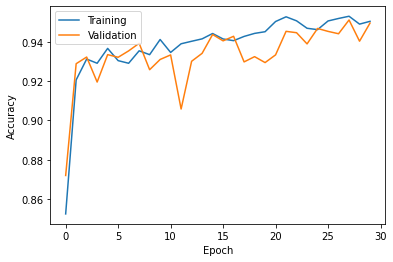

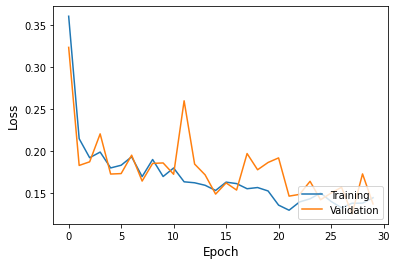

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_history['accuracy'])
plt.plot(unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')

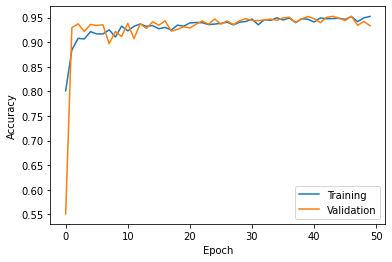

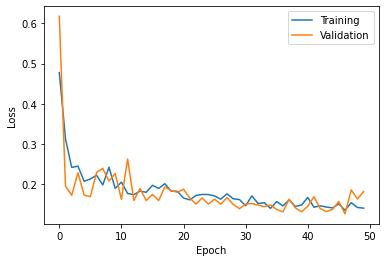

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [25]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

In [26]:
# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

In [27]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [28]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_score), np.std(unet_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

U-Net accuracy:  0.9440521240234375 0.050881220293368404
Attention U-Net accuracy:  0.9474437713623047 0.03370743628250296


In [29]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_precision), np.std(unet_precision))
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

U-Net precision:  0.953036384983934 0.03598426810054437
Attention U-Net precision:  0.951284308528517 0.02852770045296243


In [30]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_recall), np.std(unet_recall))
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

U-Net recall:  0.9440521240234375 0.050881220293368404
Attention U-Net recall:  0.9474437713623047 0.03370743628250296


In [31]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

U-Net F1-score:  0.9485229806030155
Attention U-Net F1-score:  0.949360155838497


## 4-dim

### Amazon Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

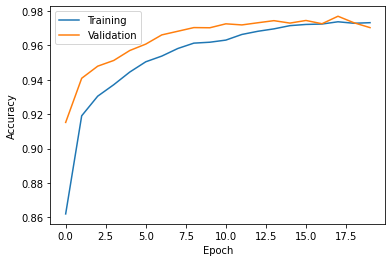

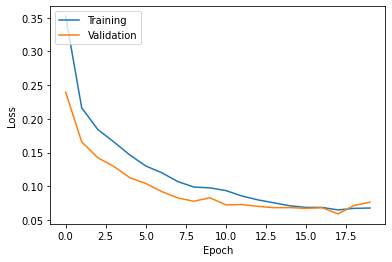

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

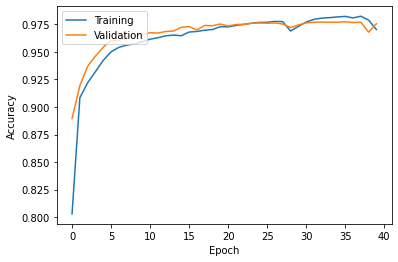

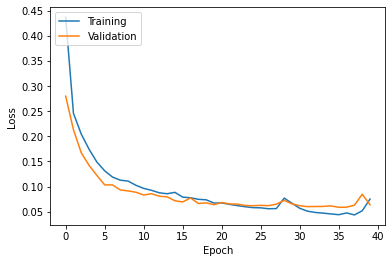

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# Precision and recall of each model
unet_4d_precision = (precision_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))

unet_4d_recall = (recall_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_4d_score), np.std(unet_4d_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

U-Net accuracy:  0.975186424255371 0.022908675073541194
Attention U-Net accuracy:  0.9779380798339844 0.021114514509621745


In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

U-Net precision:  0.9766470213835967 0.01991932006610463
Attention U-Net precision:  0.9790256930312501 0.019160716971491704


In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

U-Net recall:  0.975186424255371 0.022908675073541194
Attention U-Net recall:  0.9779380798339844 0.021114514509621745


In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

U-Net F1-score:  0.9759161763220419
Attention U-Net F1-score:  0.9784815842036023


### Amazon on unseen Atlantic data

In [ ]:
# Score
unet_amazon_on_atlantic_score = score_eval2(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
unet_amazon_on_atlantic_precision = (precision_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
unet_amazon_on_atlantic_recall = (recall_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(unet_amazon_on_atlantic_precision, unet_amazon_on_atlantic_recall))
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_amazon_on_atlantic_score), np.std(unet_amazon_on_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('U-Net precision: ', np.mean(unet_amazon_on_atlantic_precision), np.std(unet_amazon_on_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('U-Net recall: ', np.mean(unet_amazon_on_atlantic_recall), np.std(unet_amazon_on_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('U-Net F1-score: ', unet_amazon_on_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

U-Net score:  0.8846941947937011 0.08982562987777168
Attention U-Net score:  0.8828523953755697 0.10684353206781373
U-Net precision:  0.9168732192593768 0.04676348221428434
Attention U-Net precision:  0.9221976372319107 0.04420165970077992
U-Net recall:  0.8846941947937011 0.08982562987777168
Attention U-Net recall:  0.8828523953755697 0.10684353206781373
U-Net F1-score:  0.900496321273587
Attention U-Net F1-score:  0.9020962060135076


### Atlantic Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.hdf5')
unet_4d_atlantic = load_model('unet-4d-atlantic.hdf5')

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

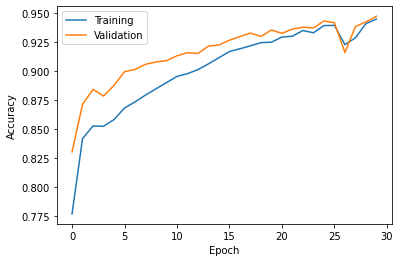

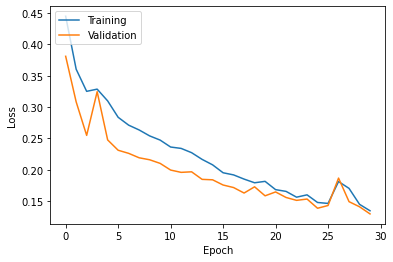

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

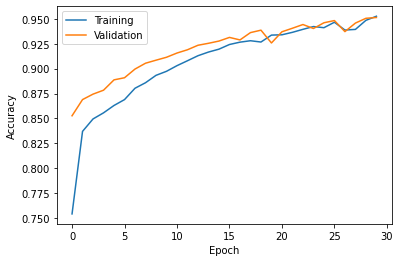

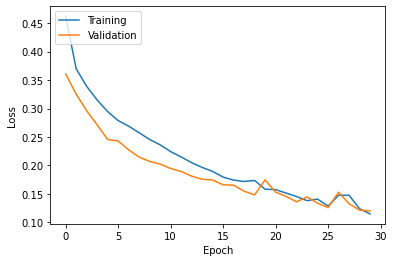

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_atlantic_score = (score_eval2(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision = (precision_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

unet_4d_atlantic_recall = (recall_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score = (f1_score_eval_basic(unet_4d_atlantic_precision, unet_4d_atlantic_recall))
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_4d_atlantic_score), np.std(unet_4d_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision), np.std(unet_4d_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall), np.std(unet_4d_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

U-Net score:  0.9346261596679688 0.05244522139820801
Attention U-Net score:  0.9519517517089844 0.030166279074064023
U-Net precision:  0.9386773001618335 0.03641260419431297
Attention U-Net precision:  0.9563236733896406 0.021722305958663538
U-Net recall:  0.9346261596679688 0.05244522139820801
Attention U-Net recall:  0.9519517517089844 0.030166279074064023
U-Net F1-score:  0.9366473494875831
Attention U-Net F1-score:  0.9541327044412243


### Atlantic on unseen Amazon data

In [ ]:
# Score
unet_atlantic_on_amazon_score = score_eval2(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
unet_atlantic_on_amazon_precision = (precision_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
unet_atlantic_on_amazon_recall = (recall_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(unet_atlantic_on_amazon_precision, unet_atlantic_on_amazon_recall))
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_atlantic_on_amazon_score), np.std(unet_atlantic_on_amazon_score))
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('U-Net precision: ', np.mean(unet_atlantic_on_amazon_precision), np.std(unet_atlantic_on_amazon_precision))
print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('U-Net recall: ', np.mean(unet_atlantic_on_amazon_recall), np.std(unet_atlantic_on_amazon_recall))
print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('U-Net F1-score: ', unet_atlantic_on_amazon_f1_score)
print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

U-Net score:  0.8915157000223796 0.0932127976762558
Attention U-Net score:  0.9266117413838705 0.05701273728830019
U-Net precision:  0.9323368415000753 0.046739859260368194
Attention U-Net precision:  0.9445315806544227 0.03958733603853125
U-Net recall:  0.8915157000223796 0.0932127976762558
Attention U-Net recall:  0.9266117413838705 0.05701273728830019
U-Net F1-score:  0.911469445016381
Attention U-Net F1-score:  0.9354858523492012


### Amazon and Atlantic unseen test data

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
unet_4d_score_test = (score_eval2(unet_4d, test_images2, test_masks2))
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
unet_4d_precision_test = (precision_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

unet_4d_recall_test = (recall_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
unet_4d_f1_score_test = (f1_score_eval_basic(unet_4d_precision_test, unet_4d_recall_test))
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
unet_4d_atlantic_score_test = (score_eval2(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision_test = (precision_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

unet_4d_atlantic_recall_test = (recall_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(unet_4d_atlantic_precision_test, unet_4d_atlantic_recall_test))
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('U-Net score: ', np.mean(unet_4d_score_test), np.std(unet_4d_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('U-Net precision: ', np.mean(unet_4d_precision_test), np.std(unet_4d_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('U-Net recall: ', np.mean(unet_4d_recall_test), np.std(unet_4d_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('U-Net F1-score: ', unet_4d_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

U-Net score:  0.9724159240722656 0.021293534825664956
Attention U-Net score:  0.9747537612915039 0.019844774736773
U-Net precision:  0.9738279305670721 0.018961125689019694
Attention U-Net precision:  0.9758240840110284 0.017958485345777382
U-Net recall:  0.9724159240722656 0.021293534825664956
Attention U-Net recall:  0.9747537612915039 0.019844774736773
U-Net F1-score:  0.9731214151119266
Attention U-Net F1-score:  0.9752886289970736


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('U-Net score: ', np.mean(unet_4d_atlantic_score_test), np.std(unet_4d_atlantic_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision_test), np.std(unet_4d_atlantic_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall_test), np.std(unet_4d_atlantic_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

U-Net score:  0.9373287200927735 0.052345346058224544
Attention U-Net score:  0.9570850372314453 0.01349322683924965
U-Net precision:  0.94243862353405 0.03593396648244278
Attention U-Net precision:  0.9590889631889825 0.0124338547954335
U-Net recall:  0.9373287200927735 0.052345346058224544
Attention U-Net recall:  0.9570850372314453 0.01349322683924965
U-Net F1-score:  0.9398767265089123
Attention U-Net F1-score:  0.9580859523619385


## ResNet50-SegNet

In [32]:
# Load ResNet models and history stats
resnet_3d = ResNet50SegNet()
resnet_3d.load_weights('resnet50segnet-3d.hdf5')
resnet_4d_amazon = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_amazon.load_weights('resnet50segnet-4d.hdf5')
resnet_4d_atlantic = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_atlantic.load_weights('resnet50segnet-4d-atlantic.hdf5')

resnet_3d_history = np.load('resnet50segnet-3d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_amazon_history = np.load('resnet50segnet-4d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_atlantic_history = np.load('resnet50segnet-4d-history-atlantic.npy', allow_pickle='TRUE').item()

In [33]:
# Metrics of each model on respective datasets

# Score
resnet_3d_score = (score_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_score = (score_eval2(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_score = (score_eval2(resnet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resnet_3d_precision = (precision_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_precision = (precision_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_precision = (precision_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

resnet_3d_recall = (recall_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_recall = (recall_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_recall = (recall_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resnet_3d_f1_score = (f1_score_eval_basic(resnet_3d_precision, resnet_3d_recall))
resnet_4d_amazon_f1_score = (f1_score_eval_basic(resnet_4d_amazon_precision, resnet_4d_amazon_recall))
resnet_4d_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_precision, resnet_4d_atlantic_recall))

In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resnet_4d_amazon_on_atlantic_score = (score_eval2(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_score = (score_eval2(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
resnet_4d_amazon_on_atlantic_precision = (precision_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_precision = (precision_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

resnet_4d_amazon_on_atlantic_recall = (recall_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_recall = (recall_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
resnet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_recall))
resnet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResNet 3-dim: ', np.mean(resnet_3d_score), np.mean(resnet_3d_precision), np.mean(resnet_3d_recall), resnet_3d_f1_score)
print('ResNet 3-dim: ', np.std(resnet_3d_score), np.std(resnet_3d_precision), np.std(resnet_3d_recall), resnet_3d_f1_score)
print('----')
print('ResNet 4-dim Amazon: ', np.mean(resnet_4d_amazon_score), np.mean(resnet_4d_amazon_precision), np.mean(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('ResNet 4-dim Amazon: ', np.std(resnet_4d_amazon_score), np.std(resnet_4d_amazon_precision), np.std(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('----')
print('ResNet 4-dim Atlantic: ', np.mean(resnet_4d_atlantic_score), np.mean(resnet_4d_atlantic_precision), np.mean(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('ResNet 4-dim Atlantic: ', np.std(resnet_4d_atlantic_score), np.std(resnet_4d_atlantic_precision), np.std(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('----')
print('ResNet 4-dim Amazon on Atlantic: ', np.mean(resnet_4d_amazon_on_atlantic_score), np.mean(resnet_4d_amazon_on_atlantic_precision), np.mean(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('ResNet 4-dim Amazon on Atlantic: ', np.std(resnet_4d_amazon_on_atlantic_score), np.std(resnet_4d_amazon_on_atlantic_precision), np.std(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResNet 4-dim Atlantic on Amazon: ', np.mean(resnet_4d_atlantic_on_amazon_score), np.mean(resnet_4d_atlantic_on_amazon_precision), np.mean(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)
print('ResNet 4-dim Atlantic on Amazon: ', np.std(resnet_4d_atlantic_on_amazon_score), np.std(resnet_4d_atlantic_on_amazon_precision), np.std(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
ResNet 3-dim:  0.9546510696411132 0.9593176279376037 0.9546510696411132 0.9569786598858873
ResNet 3-dim:  0.03987267609550673 0.033383441312818375 0.03987267609550673 0.9569786598858873
----
ResNet 4-dim Amazon:  0.9717498397827149 0.9733257837688447 0.9717498397827149 0.9725371733431613
ResNet 4-dim Amazon:  0.023450585104448734 0.02046346591517085 0.023450585104448734 0.9725371733431613
----
ResNet 4-dim Atlantic:  0.947955093383789 0.9513523840356695 0.947955093383789 0.9496507003434008
ResNet 4-dim Atlantic:  0.027626663710908578 0.02224421083691322 0.027626663710908578 0.9496507003434008
----
ResNet 4-dim Amazon on Atlantic:  0.8669666608174642 0.915592527163881 0.8669666608174642 0.890616369202996
ResNet 4-dim Amazon on Atlantic:  0.11444763701614054 0.04198269756948197 0.11444763701614054 0.890616369202996
----
ResNet 4-dim Atlantic on Amazon:  0.9087992350260417 0.9355350272526637 0.9087992350260417 0.9219733477778967
ResNet 4-dim Atlant

### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
resnet_4d_score_test = (score_eval2(resnet_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
resnet_4d_precision_test = (precision_eval(resnet_4d_amazon, test_images2, test_masks2))
resnet_4d_recall_test = (recall_eval(resnet_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
resnet_4d_f1_score_test = (f1_score_eval_basic(resnet_4d_precision_test, resnet_4d_recall_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
resnet_4d_atlantic_score_test = (score_eval2(resnet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
resnet_4d_atlantic_precision_test = (precision_eval(resnet_4d_atlantic, test_images3, test_masks3))
resnet_4d_atlantic_recall_test = (recall_eval(resnet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
resnet_4d_atlantic_f1_score_test = (f1_score_eval_basic(resnet_4d_atlantic_precision_test, resnet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('ResNet score: ', np.mean(resnet_4d_score_test), np.std(resnet_4d_score_test))
print('ResNet precision: ', np.mean(resnet_4d_precision_test), np.std(resnet_4d_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_recall_test), np.std(resnet_4d_recall_test))
print('ResNet F1-score: ', resnet_4d_f1_score_test)

ResNet score:  0.969398307800293 0.021191613151098125
ResNet precision:  0.9707419790017067 0.01862770122766578
ResNet recall:  0.969398307800293 0.021191613151098125
ResNet F1-score:  0.970069678111889


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('ResNet score: ', np.mean(resnet_4d_atlantic_score_test), np.std(resnet_4d_atlantic_score_test))
print('ResNet precision: ', np.mean(resnet_4d_atlantic_precision_test), np.std(resnet_4d_atlantic_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_atlantic_recall_test), np.std(resnet_4d_atlantic_recall_test))
print('ResNet F1-score: ', resnet_4d_atlantic_f1_score_test)

ResNet score:  0.9465770721435547 0.02797195602803041
ResNet precision:  0.9510178513149314 0.019663765108312733
ResNet recall:  0.9465770721435547 0.02797195602803041
ResNet F1-score:  0.9487922655413198


## FCN32-VGG16

In [35]:
#FCN32_3d = fcn_32(input_size=(512,512,3), lr = 0.0001)
#FCN32_4d_amazon = fcn_32(input_size=(512,512,4), lr = 0.0001)
#FCN32_4d_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)

# Load FCN models and history stats
#FCN32_3d.load_weights('fcn32-3d-weights.h5')
#FCN32_4d_amazon.load_weights('fcn32-4d-weights.h5')
#FCN32_4d_atlantic.load_weights('fcn32-4d-atlantic-weights.h5')
#fcn32_3d = FCN32_3d
#fcn32_4d_amazon = FCN32_4d_amazon
#fcn32_4d_atlantic = FCN32_4d_atlantic

fcn32_3d = load_model('fcn32-3d.hdf5')
fcn32_4d_amazon = load_model('fcn32-4d.hdf5')
fcn32_4d_atlantic = load_model('fcn32-4d-atlantic.hdf5')

fcn32_3d_history = np.load('fcn32-3d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_amazon_history = np.load('fcn32-4d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_atlantic_history = np.load('fcn32-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [36]:
# Metrics of each model on respective datasets

# Score
fcn32_3d_score = (score_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_score = (score_eval2(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_score = (score_eval2(fcn32_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
fcn32_3d_precision = (precision_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_precision = (precision_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_precision = (precision_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

fcn32_3d_recall = (recall_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_recall = (recall_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_recall = (recall_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

# F1-score
fcn32_3d_f1_score = (f1_score_eval_basic(fcn32_3d_precision, fcn32_3d_recall))
fcn32_4d_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_precision, fcn32_4d_amazon_recall))
fcn32_4d_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_precision, fcn32_4d_atlantic_recall))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
fcn32_4d_amazon_on_atlantic_score = (score_eval2(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_score = (score_eval2(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
fcn32_4d_amazon_on_atlantic_precision = (precision_eval(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_precision = (precision_eval(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

fcn32_4d_amazon_on_atlantic_recall = (recall_eval(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_recall = (recall_eval(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
fcn32_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_recall))
fcn32_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('FCN32 3-dim: ', np.mean(fcn32_3d_score), np.mean(fcn32_3d_precision), np.mean(fcn32_3d_recall), fcn32_3d_f1_score)
print('FCN32 3-dim: ', np.std(fcn32_3d_score), np.std(fcn32_3d_precision), np.std(fcn32_3d_recall), fcn32_3d_f1_score)
print('----')
print('FCN32 4-dim Amazon: ', np.mean(fcn32_4d_amazon_score), np.mean(fcn32_4d_amazon_precision), np.mean(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('FCN32 4-dim Amazon: ', np.std(fcn32_4d_amazon_score), np.std(fcn32_4d_amazon_precision), np.std(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('----')
print('FCN32 4-dim Atlantic: ', np.mean(fcn32_4d_atlantic_score), np.mean(fcn32_4d_atlantic_precision), np.mean(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('FCN32 4-dim Atlantic: ', np.std(fcn32_4d_atlantic_score), np.std(fcn32_4d_atlantic_precision), np.std(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('----')
print('FCN32 4-dim Amazon on Atlantic: ', np.mean(fcn32_4d_amazon_on_atlantic_score), np.mean(fcn32_4d_amazon_on_atlantic_precision), np.mean(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('FCN32 4-dim Amazon on Atlantic: ', np.std(fcn32_4d_amazon_on_atlantic_score), np.std(fcn32_4d_amazon_on_atlantic_precision), np.std(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('----')
print('FCN32 4-dim Atlantic on Amazon: ', np.mean(fcn32_4d_atlantic_on_amazon_score), np.mean(fcn32_4d_atlantic_on_amazon_precision), np.mean(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)
print('FCN32 4-dim Atlantic on Amazon: ', np.std(fcn32_4d_atlantic_on_amazon_score), np.std(fcn32_4d_atlantic_on_amazon_precision), np.std(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
FCN32 3-dim:  0.9057222366333008 0.9070766675622972 0.9057222366333008 0.9063989461169268
FCN32 3-dim:  0.0700558101679575 0.06652373293093729 0.0700558101679575 0.9063989461169268
----
FCN32 4-dim Amazon:  0.9213931274414062 0.9210134599410594 0.9213931274414062 0.921203254571906
FCN32 4-dim Amazon:  0.04291320110778315 0.040370747877461206 0.04291320110778315 0.921203254571906
----
FCN32 4-dim Atlantic:  0.8289618682861328 0.8318561058932089 0.8289618682861328 0.8304064652566173
FCN32 4-dim Atlantic:  0.06030172229358663 0.05248831179343837 0.06030172229358663 0.8304064652566173
----
FCN32 4-dim Amazon on Atlantic:  0.7929513613382976 0.824611128750126 0.7929513613382976 0.8084714143950984
FCN32 4-dim Amazon on Atlantic:  0.1094231182921487 0.057671830561511025 0.1094231182921487 0.8084714143950984
----
FCN32 4-dim Atlantic on Amazon:  0.8749940236409505 0.8985221083094258 0.8749940236409505 0.8866020000792557
FCN32 4-dim Atlantic on Amazon:  

### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
fcn32_4d_score_test = (score_eval2(fcn32_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
fcn32_4d_precision_test = (precision_eval(fcn32_4d_amazon, test_images2, test_masks2))
fcn32_4d_recall_test = (recall_eval(fcn32_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
fcn32_4d_f1_score_test = (f1_score_eval_basic(fcn32_4d_precision_test, fcn32_4d_recall_test))

In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
fcn32_4d_atlantic_score_test = (score_eval2(fcn32_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
fcn32_4d_atlantic_precision_test = (precision_eval(fcn32_4d_atlantic, test_images3, test_masks3))
fcn32_4d_atlantic_recall_test = (recall_eval(fcn32_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
fcn32_4d_atlantic_f1_score_test = (f1_score_eval_basic(fcn32_4d_atlantic_precision_test, fcn32_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('FCN32 score: ', np.mean(fcn32_4d_score_test), np.std(fcn32_4d_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_precision_test), np.std(fcn32_4d_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_recall_test), np.std(fcn32_4d_recall_test))
print('FCN32 F1-score: ', fcn32_4d_f1_score_test)

FCN32 score:  0.9204916000366211 0.031370949917089476
FCN32 precision:  0.9211980700523021 0.029419851109199806
FCN32 recall:  0.9204916000366211 0.031370949917089476
FCN32 F1-score:  0.9208446995439235


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('FCN32 score: ', np.mean(fcn32_4d_atlantic_score_test), np.std(fcn32_4d_atlantic_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_atlantic_precision_test), np.std(fcn32_4d_atlantic_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_atlantic_recall_test), np.std(fcn32_4d_atlantic_recall_test))
print('FCN32 F1-score: ', fcn32_4d_atlantic_f1_score_test)

FCN32 score:  0.8076549530029297 0.08254624208056892
FCN32 precision:  0.8185838777023733 0.05506081940156744
FCN32 recall:  0.8076549530029297 0.08254624208056892
FCN32 F1-score:  0.8130826921503669


# Produce metric datasets for export

## 3-dim data

In [37]:
scores_3d = [unet_score, am_unet_score, resnet_3d_score, fcn32_3d_score]
precision_3d = [unet_precision, am_unet_precision, resnet_3d_precision, fcn32_3d_precision]
recall_3d = [unet_recall, am_unet_recall, resnet_3d_recall, fcn32_3d_recall]
f1_scores_3d = [unet_f1_score, am_unet_f1_score, resnet_3d_f1_score, fcn32_3d_f1_score]

import pandas as pd
metrics_3d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)
metrics_3d.to_csv('metrics_3d.csv')

## 4-band Amazon data

In [ ]:
scores_4d = [unet_4d_score, am_unet_4d_score, resnet_4d_amazon_score, fcn32_4d_amazon_score]
precision_4d = [unet_4d_precision, am_unet_4d_precision, resnet_4d_amazon_precision, fcn32_4d_amazon_precision]
recall_4d = [unet_4d_recall, am_unet_4d_recall, resnet_4d_amazon_recall, fcn32_4d_amazon_recall]
f1_scores_4d = [unet_4d_f1_score, am_unet_4d_f1_score, resnet_4d_amazon_f1_score, fcn32_4d_amazon_f1_score]

metrics_4d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_4d_amazon.csv')

## 4-band Atlantic Forest data

In [ ]:
scores_4d_atl = [unet_4d_atlantic_score, am_unet_4d_atlantic_score, resnet_4d_atlantic_score, fcn32_4d_atlantic_score]
precision_4d_atl = [unet_4d_atlantic_precision, am_unet_4d_atlantic_precision, resnet_4d_atlantic_precision, fcn32_4d_atlantic_precision]
recall_4d_atl = [unet_4d_atlantic_recall, am_unet_4d_atlantic_recall, resnet_4d_atlantic_recall, fcn32_4d_atlantic_recall]
f1_scores_4d_atl = [unet_4d_atlantic_f1_score, am_unet_4d_atlantic_f1_score, resnet_4d_atlantic_f1_score, fcn32_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_4d_atlantic_forest.csv')

## Test set data

In [ ]:
scores_4d_test = [unet_4d_score_test, am_unet_4d_score_test, resnet_4d_score_test, fcn32_4d_score_test]
precision_4d_test = [unet_4d_precision_test, am_unet_4d_precision_test, resnet_4d_precision_test, fcn32_4d_precision_test]
recall_4d_test = [unet_4d_recall_test, am_unet_4d_recall_test, resnet_4d_recall_test, fcn32_4d_recall_test]
f1_scores_4d_test = [unet_4d_f1_score_test, am_unet_4d_f1_score_test, resnet_4d_f1_score_test, fcn32_4d_f1_score_test]

metrics_4d_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_4d_amazon_test.csv')

In [ ]:
scores_4d_atl_test = [unet_4d_atlantic_score_test, am_unet_4d_atlantic_score_test, resnet_4d_atlantic_score_test, fcn32_4d_atlantic_score_test]
precision_4d_atl_test = [unet_4d_atlantic_precision_test, am_unet_4d_atlantic_precision_test, resnet_4d_atlantic_precision_test, fcn32_4d_atlantic_precision_test]
recall_4d_atl_test = [unet_4d_atlantic_recall_test, am_unet_4d_atlantic_recall_test, resnet_4d_atlantic_recall_test, fcn32_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [unet_4d_atlantic_f1_score_test, am_unet_4d_atlantic_f1_score_test, resnet_4d_atlantic_f1_score_test, fcn32_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_4d_atlantic_forest_test.csv')

## Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [ ]:
scores_amazon_on_atlantic = [unet_amazon_on_atlantic_score, am_unet_amazon_on_atlantic_score, resnet_4d_amazon_on_atlantic_score, fcn32_4d_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [unet_amazon_on_atlantic_recall, am_unet_amazon_on_atlantic_recall, resnet_4d_amazon_on_atlantic_recall, fcn32_4d_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [unet_amazon_on_atlantic_f1_score, am_unet_amazon_on_atlantic_f1_score, resnet_4d_amazon_on_atlantic_f1_score, fcn32_4d_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_4d_amazon_on_atlantic.csv')

In [ ]:
scores_atlantic_on_amazon = [unet_atlantic_on_amazon_score, am_unet_atlantic_on_amazon_score, resnet_4d_atlantic_on_amazon_score, fcn32_4d_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [unet_atlantic_on_amazon_recall, am_unet_atlantic_on_amazon_recall, resnet_4d_atlantic_on_amazon_recall, fcn32_4d_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [unet_atlantic_on_amazon_f1_score, am_unet_atlantic_on_amazon_f1_score, resnet_4d_atlantic_on_amazon_f1_score, fcn32_4d_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_4d_atlantic_on_amazon.csv')